# Imports 
Necessary imports, based in part on [this](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook)

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

# deep learning
import keras_cv
import keras
from keras import ops
import tensorflow as tf
import cv2
import umap.umap_ as umap

# data processing
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

2024-03-07 17:03:48.232390: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 17:03:48.541253: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 17:03:49.147719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 17:03:51.320456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/applesauce/vu-ml-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [92]:
import model

nn = model.Model("model1")

print(nn.name) # model1

model1


# Data pre-processing

## Loading
The general format of each instance of the data is 
```
[ids*, ancillary data*, trait means*, traits sd*, image path]
```

In [93]:
from config import config
DATA_PATH = "../data"

# creating df that has image path and related ancillary data
df = pd.read_csv(DATA_PATH + "/train.csv")
df['image_path'] = f'{DATA_PATH}/train_images/' + str(df['id']) + '.jpeg'
df.loc[:, config.aux_class_names] = df.loc[:, config.aux_class_names].fillna(-1)
display(df.head(2))
print(df.shape[0]) 

# same df but for the test data
test_df = pd.read_csv(DATA_PATH + "/test.csv")
df['image_path'] = f'{DATA_PATH}/test_images'+ str(test_df['id']) + '.jpeg'
FEATURE_COLS = list(test_df.columns[1:-1])
display(test_df.head(2))
print(test_df.shape[0])

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/0 192027691\n1 ...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/0 192027691\n1 ...


55489


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.440003,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.434866,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728


13873


## traits

### mean traits

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034
1,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472


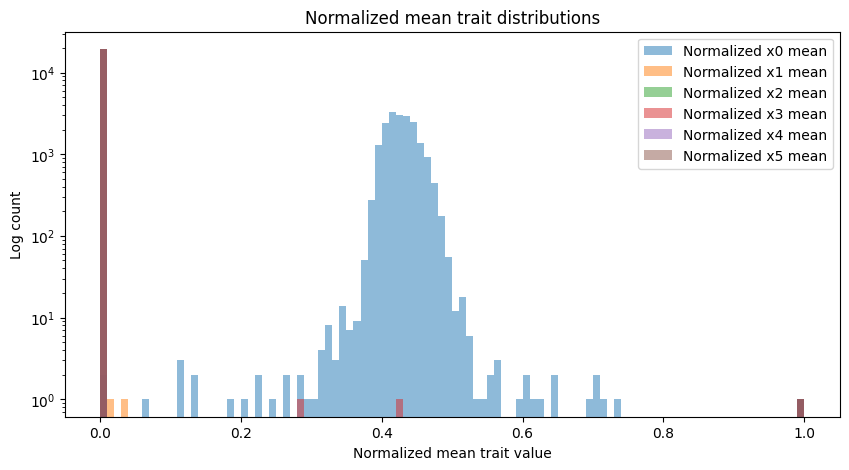

In [94]:
mean_traits = df.iloc[:, 164:170]
sd_traits = df.iloc[:, 170:176]
display(mean_traits.head(2))


def mean_normalizer(col):
    mean = mean_traits.iloc[:, col]
    mean = mean.drop_duplicates()
    return (mean - mean.min()) / (mean.max() - mean.min())

plt.figure(figsize=(10, 5))
for i in range(6): 
    plt.hist(mean_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized x{i} mean')
    
plt.title('Normalized mean trait distributions')
plt.xlabel('Normalized mean trait value')
plt.ylabel('Log count')
plt.legend()
plt.show()

19009


Text(0, 0.5, 'Instance count')

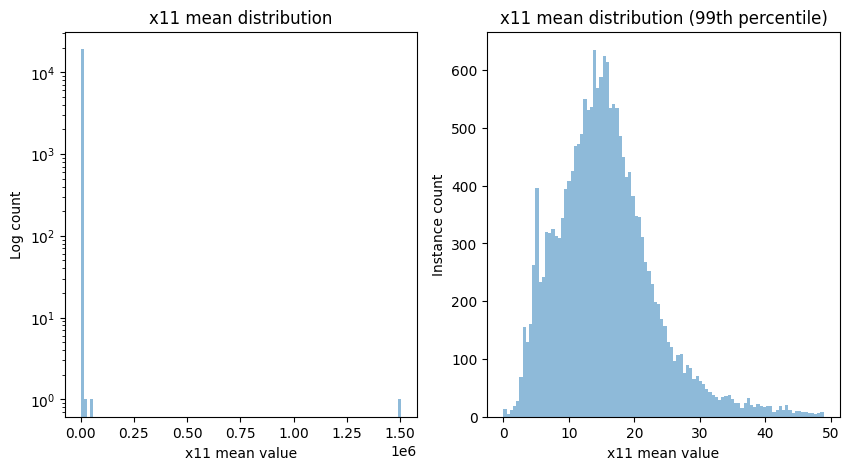

In [95]:
x_11_mean = mean_traits.iloc[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# remove outliers
x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(1))]

x_11_mean = x_11_mean.drop_duplicates()

ax[0].hist(x_11_mean, bins=100, log=True, alpha=0.5)
ax[0].set_title('x11 mean distribution')
ax[0].set_xlabel('x11 mean value')
ax[0].set_ylabel('Log count')

x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(0.99))]
print(x_11_mean.count())
ax[1].hist(x_11_mean, bins=100, alpha=0.5)
ax[1].set_title('x11 mean distribution (99th percentile)')
ax[1].set_xlabel('x11 mean value')
ax[1].set_ylabel('Instance count')

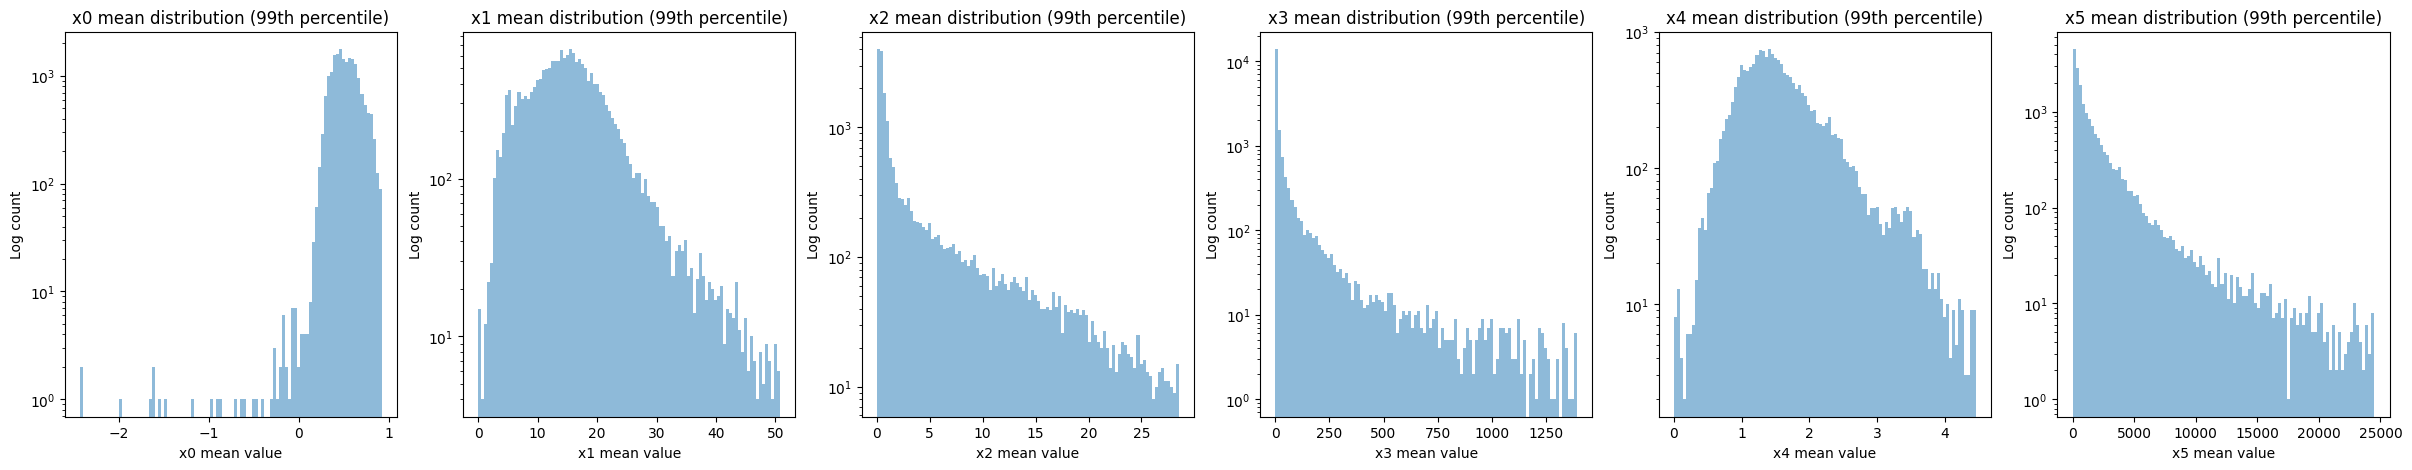

In [96]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

for i in range(6):
    x_mean = mean_traits.iloc[:, i]
    x_mean = x_mean[x_mean.between(x_mean.quantile(0), x_mean.quantile(0.99))]
    x_mean = x_mean.drop_duplicates()
    
    ax[i].hist(x_mean, bins=100, log=True, alpha=0.5, label=f'Normalized x{i} mean')
    ax[i].set_title(f'x{i} mean distribution (99th percentile)')
    ax[i].set_xlabel(f'x{i} mean value')
    ax[i].set_ylabel('Log count')

### sd traits

,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477


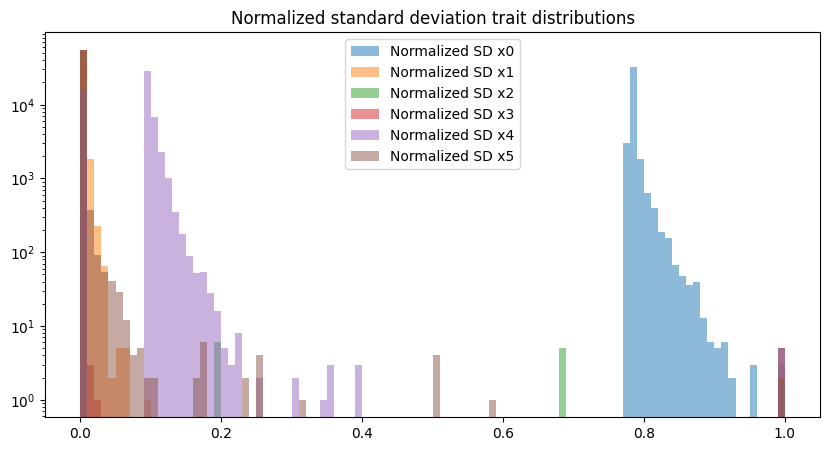

In [97]:
sd_traits = df.iloc[:, 170:176]
display(sd_traits.head(2))
def sd_normalizer(col):
    sd = sd_traits.iloc[:, col]
    return (sd - sd.min()) / (sd.max() - sd.min())

plt.figure(figsize=(10, 5))
for i in range(6):  
    plt.hist(sd_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized SD x{i}')

plt.title('Normalized standard deviation trait distributions')
plt.legend()
plt.show()


## ancillary data

<Figure size 1000x1000 with 0 Axes>

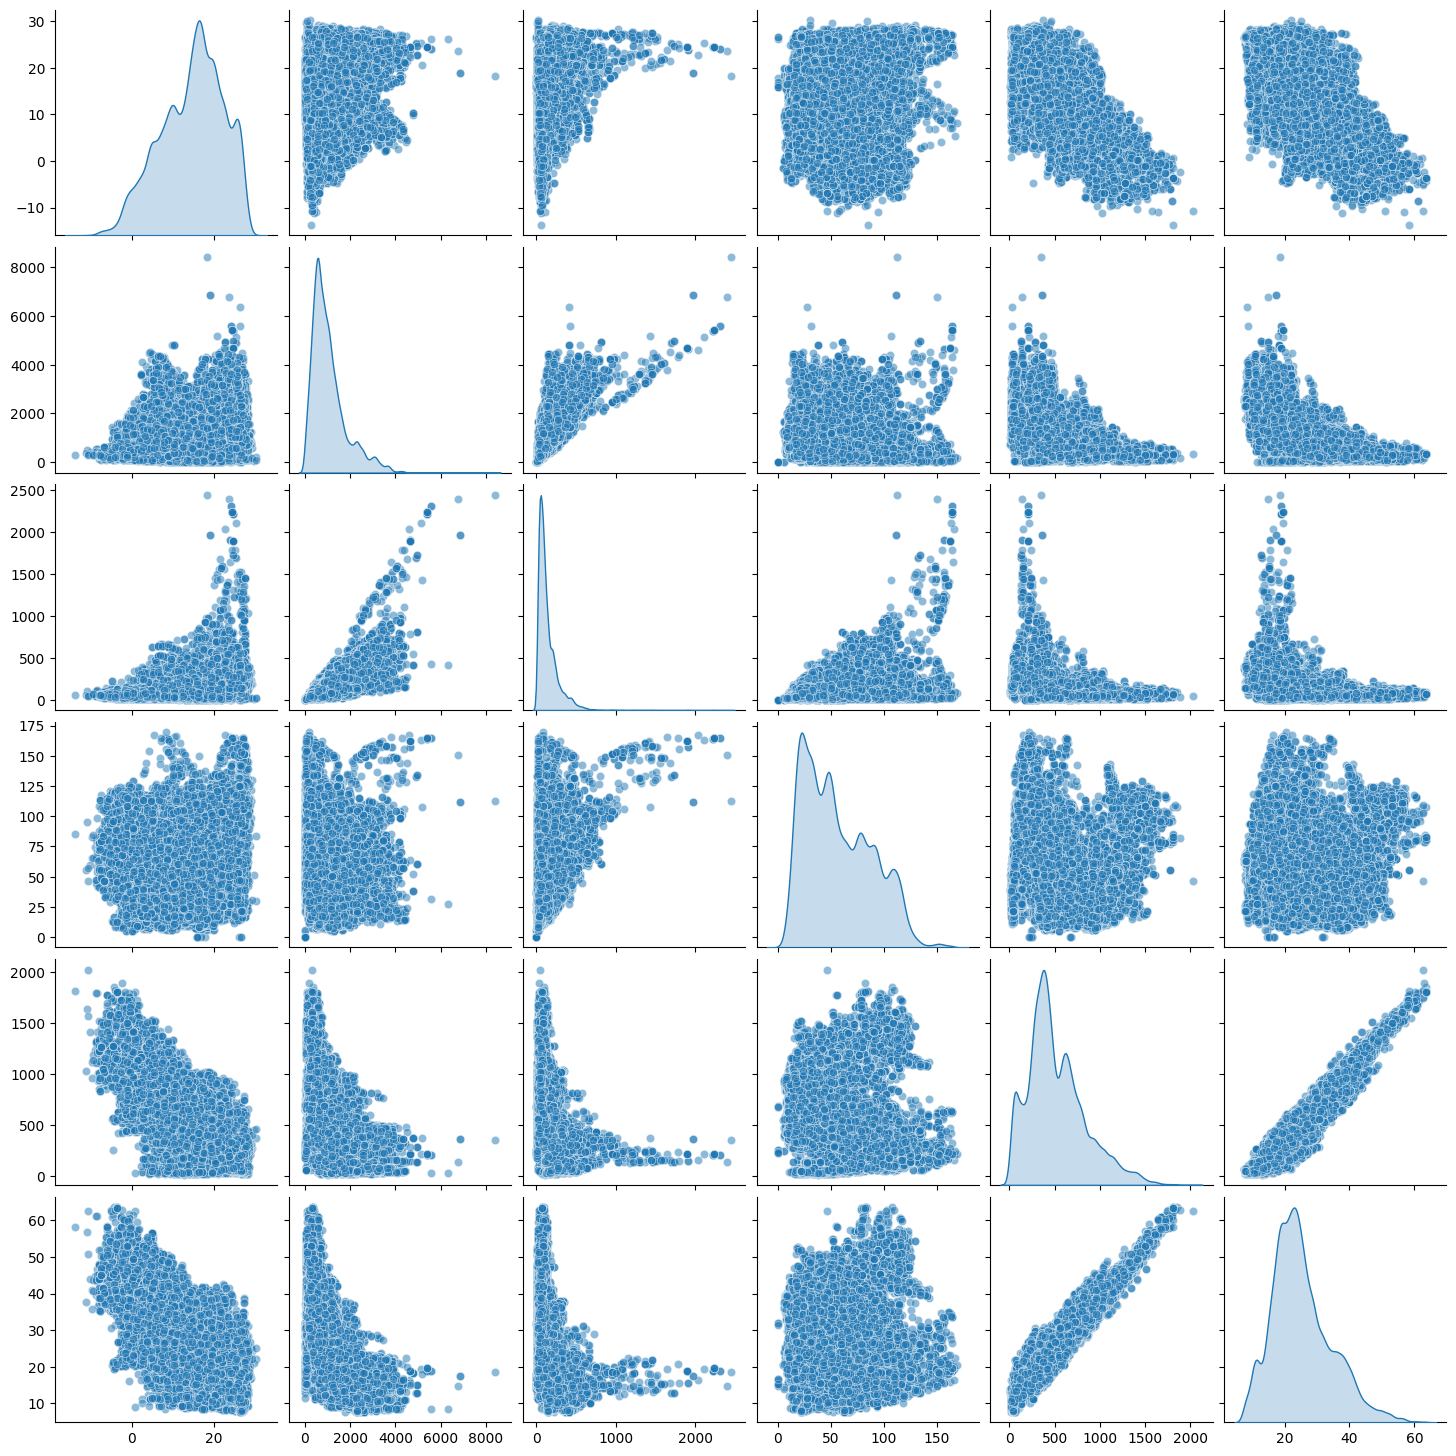

In [109]:
ancillary_data = df.iloc[:, 1:164]

fig = plt.figure(figsize=(10, 10))

# worldclim 
worldclim = ancillary_data.filter(like='WORLDCLIM')

g = sns.pairplot(worldclim, diag_kind='kde', plot_kws={'alpha': 0.5})

# remove labels 
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

[('WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range')]


Text(0.5, 0.92, 'UMAP embedding of worldclim features')

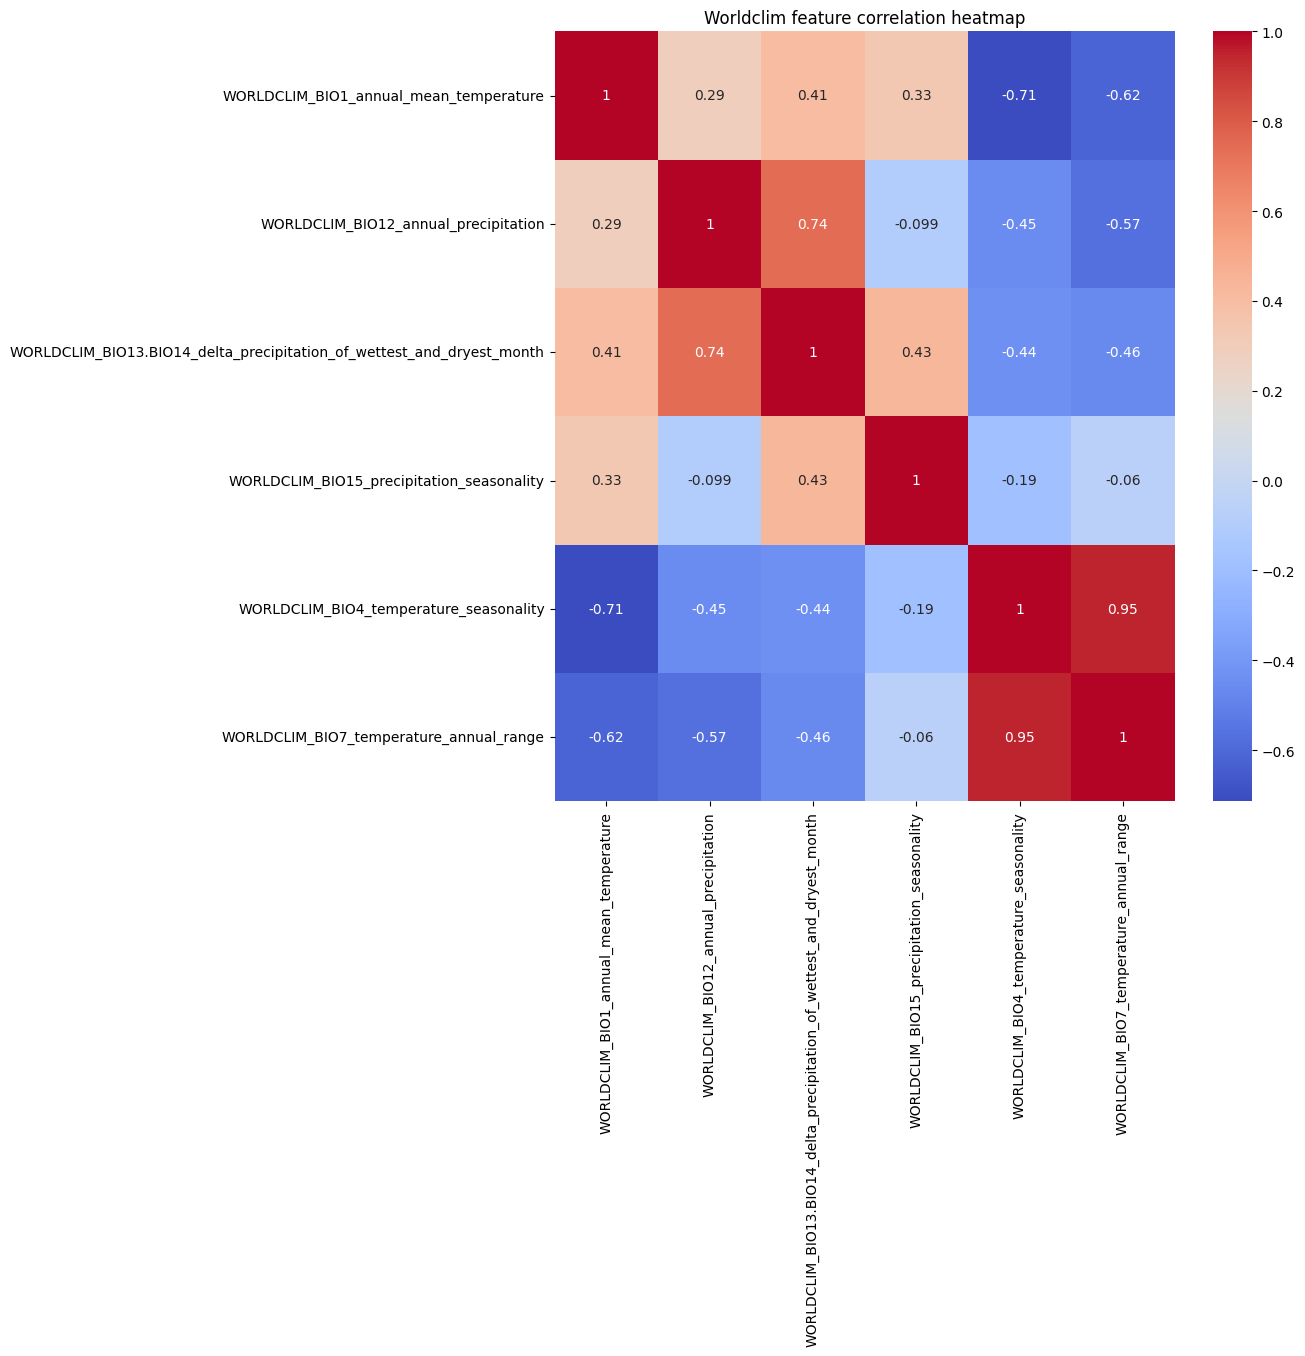

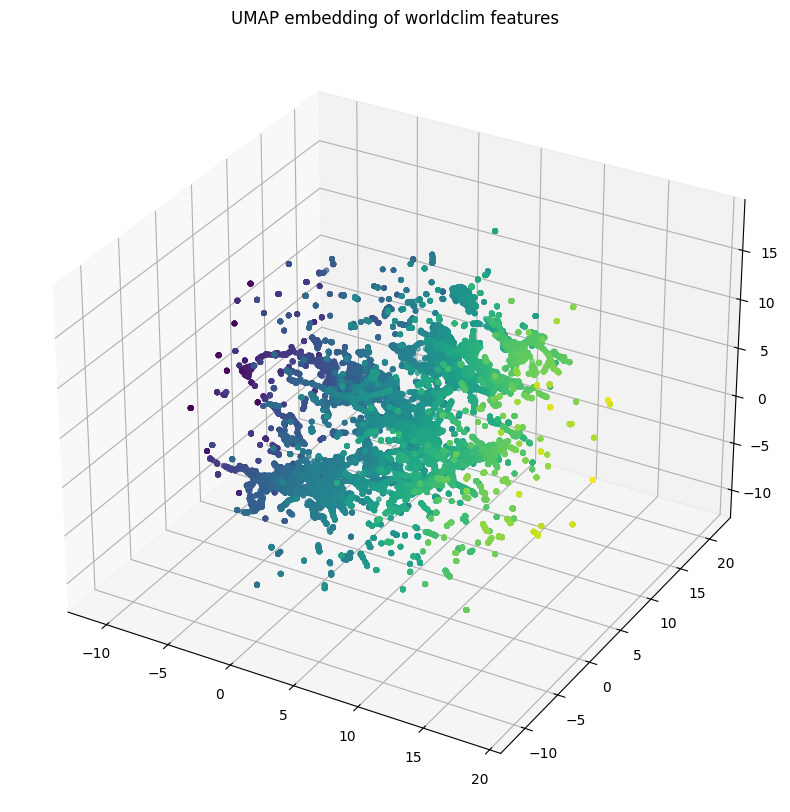

: 

In [112]:
worldclim   = ancillary_data.filter(like='WORLDCLIM')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))


corr = worldclim.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)
ax.set_title('Worldclim feature correlation heatmap')

high_corr = [
    i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]
]

high_corr = list(set([tuple(sorted(i)) for i in high_corr]))

print(high_corr)

reducer = umap.UMAP(n_components=3)

scaled_worldclim_data = (worldclim - worldclim.min()) / (worldclim.max() - worldclim.min())

embedding = reducer.fit_transform(scaled_worldclim_data)
embedding.shape 

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=embedding[:, 0], cmap='viridis', s=10)

ax.set_title('UMAP embedding of worldclim features')


In [ ]:
ancillary_data = df.iloc[:, 1:164]
 
# select allcolumns with a name containing WORLDCLIM
worldclim   = ancillary_data.filter(like='WORLDCLIM')
soil        = ancillary_data.filter(like='SOIL')
modis       = ancillary_data.filter(like='MODIS')
vod         = ancillary_data.filter(like='VOD')

print(
    f"lengths {len(worldclim.columns)}, {len(soil.columns)}, {len(modis.columns)}, {len(vod.columns)}"
)
    

lengths 6, 61, 60, 36


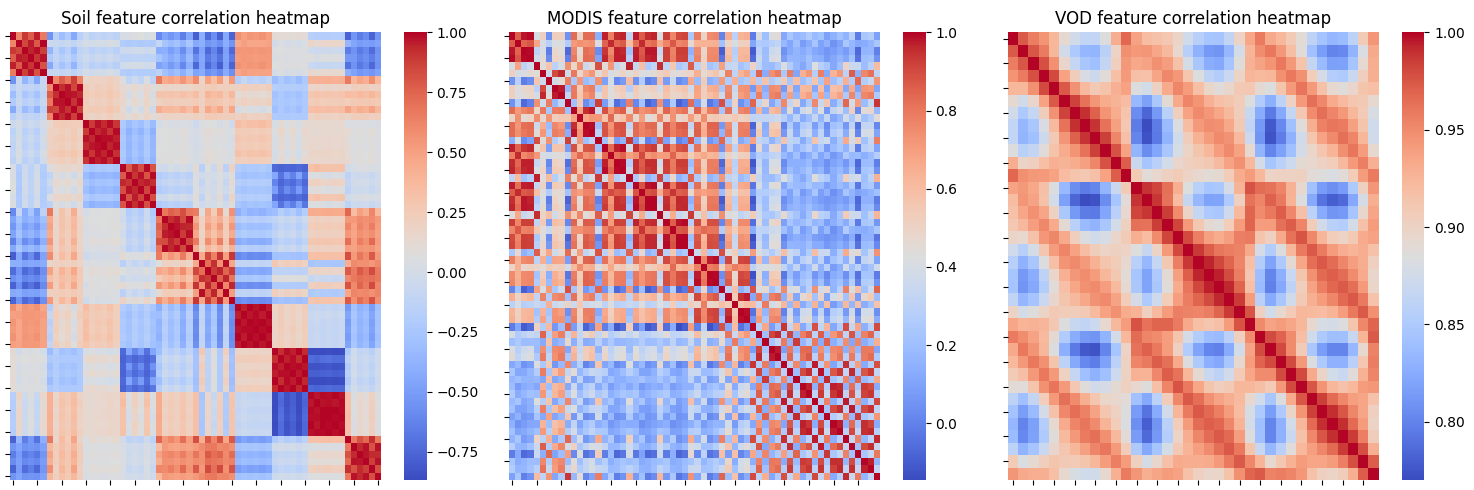

In [ ]:
# 3 x 1 subplot of correlation heatmaps 

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# soil 

soil_corr = soil.corr()
sns.heatmap(soil_corr, ax=ax[0], cmap='coolwarm', annot=False)

ax[0].set_title('Soil feature correlation heatmap')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

# modis

modis_corr = modis.corr()
sns.heatmap(modis_corr, ax=ax[1], cmap='coolwarm', annot=False)

ax[1].set_title('MODIS feature correlation heatmap')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# vod

vod_corr = vod.corr()
sns.heatmap(vod_corr, ax=ax[2], cmap='coolwarm', annot=False)

ax[2].set_title('VOD feature correlation heatmap')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])

fig.tight_layout()
plt.show()

## missing data

In [ ]:
# iter over all rows in df and look for missing data

bad_rows = []
class_names = [n for n in config.aux_class_names if n.startswith("X") and n.endswith("_sd")]  # there is some missing data in the X*_sd columns
for i, row in df.iterrows():
    # check if any of those is a 0, -1 or 1
    if row[class_names].isin([0, -1, 1]).any():
        bad_rows.append(i)

# remove duplicates
bad_rows = set(bad_rows)
percentage_bad = len(bad_rows) / len(df) * 100
print(f"Found {len(bad_rows)} bad rows ({len(bad_rows)}/{len(df)}) ({percentage_bad:.2f}%)")

# display top 5 bad rows
df.iloc[list(bad_rows)].tail(5)

Found 16387 bad rows (16387/55489) (29.53%)


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
32747,191678286,4.770089,692.285706,121.321426,74.723480,1223.375732,43.067856,122,134,129,...,0.813559,1.618362,756.065369,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,../data/test_images0 195066138\n1 ...
32748,169720591,27.589434,668.857117,206.678574,127.951630,331.126221,23.382143,144,145,146,...,0.041478,1.453976,390.288831,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,../data/test_images0 195066138\n1 ...
32751,195750565,11.420621,910.806152,82.265305,38.219875,398.547119,21.381632,92,130,105,...,1.087155,1.553402,627.349084,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,../data/test_images0 195066138\n1 ...
32760,189290229,21.032909,1724.795898,80.586731,15.734583,389.696411,21.871428,119,135,125,...,5.363239,1.436706,870.423937,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,../data/test_images0 195066138\n1 ...
32764,195234253,19.248205,800.484436,75.800003,35.590511,729.131226,33.413334,156,173,162,...,0.816707,1.376163,2390.618918,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,../data/test_images0 195066138\n1 ...


### where ?

Features marked as `X*_sd` are missing for almost 30% of the data (16387/55489) (29.53%). The rest of the data seems to be complete, with no other missing/zeroed values. We can ignore these rows, or we can simply ignore those features as it is a significant amount of data.

## data augmentation

## data split